In [124]:
!pip3 install google-cloud-aiplatform --user
!pip3 install pyarrow==11.0.0 --user
!pip3 install --upgrade google-cloud-bigquery --user
!pip3 install --upgrade google-cloud-bigquery-storage --user
!pip3 install --upgrade google-cloud-storage --user
!pip install db-dtypes



In [125]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

In [126]:
BQ_LOCATION = 'US'
REGION = 'us-west1'

In [127]:
# Create a GC Storage bucket for later artifact storage
GCS_BUCKET = f"{PROJECT_ID}-k_capbucket"

In [128]:
!gsutil mb -l $REGION gs://$GCS_BUCKET

Creating gs://york-bb-cohort-k_capbucket/...
ServiceException: 409 A Cloud Storage bucket named 'york-bb-cohort-k_capbucket' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [129]:
#bq --location=us mk --dataset <project_id>:my_dataset
BQ_DATASET = f"{PROJECT_ID}:p_bq"

In [130]:
!bq mk --location={BQ_LOCATION} --dataset {BQ_DATASET}

BigQuery error in mk operation: Dataset 'york-bb-cohort:p_bq' already exists.


In [131]:
import pandas as pd
from google.cloud import aiplatform as vertexai
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [135]:
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{GCS_BUCKET}")

In [136]:
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

In [137]:
%%bigquery --project $PROJECT_ID
 SELECT * FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201705*`

TABLESAMPLE SYSTEM (2 PERCENT)



Query is running:   0%|          |

Downloading:   0%|          |

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,channelGrouping,socialEngagementType
0,<NA>,1,1496061209,1496061209,20170529,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'North...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 5, 'minut...",6191792341547686284,None,Organic Search,Not Socially Engaged
1,<NA>,1,1496062816,1496062816,20170529,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Southea...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 6, 'minut...",9900261197529675655,None,Organic Search,Not Socially Engaged
2,<NA>,2,1496114639,1496114639,20170529,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Firefox', 'browserVersion': 'not ...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 20, 'minu...",9834417162753141402,None,Organic Search,Not Socially Engaged
3,<NA>,1,1496056984,1496056984,20170529,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'UC Browser', 'browserVersion': 'n...","{'continent': 'Asia', 'subContinent': 'Souther...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 4, 'minut...",713301014142357023,None,Organic Search,Not Socially Engaged
4,<NA>,1,1496125534,1496125534,20170529,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'UC Browser', 'browserVersion': 'n...","{'continent': 'Asia', 'subContinent': 'Southea...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 23, 'minu...",0610980819864060301,None,Organic Search,Not Socially Engaged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,<NA>,1,1496095228,1496095228,20170529,"{'visits': 1, 'hits': 72, 'pageviews': 51, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 15, 'minu...",0573333173408204990,None,Direct,Not Socially Engaged
1741,<NA>,1,1496079580,1496079580,20170529,"{'visits': 1, 'hits': 102, 'pageviews': 73, 't...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 10, 'minu...",4876602137205445870,None,Organic Search,Not Socially Engaged
1742,<NA>,1,1496109097,1496109097,20170529,"{'visits': 1, 'hits': 130, 'pageviews': 77, 't...","{'referralPath': '/', 'campaign': '(not set)',...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 18, 'minu...",9820981713611818804,None,Referral,Not Socially Engaged
1743,<NA>,4,1496118354,1496118354,20170529,"{'visits': 1, 'hits': 146, 'pageviews': 99, 't...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Eastern...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 21, 'minu...",2943746373898362304,None,Referral,Not Socially Engaged


UNNESTING TABLES

In [138]:

from google.cloud.bigquery import Client, QueryJobConfig
client = Client()
query="""SELECT
date,
fullVisitorId,
userId,
h.hitNumber,
h.time,
h.hour,
h.minute,
h.isInteraction,
h.isEntrance,
h.isExit,
h.type,
h.dataSource,
h.item.productName,
h.item.productCategory,
h.item.productSku,
h.item.itemQuantity,
h.item.currencyCode,
h.appInfo.name,
h.exceptionInfo.description,
h.exceptionInfo.exceptions,
hp.productSKU,
hp.v2ProductName,
hp.v2ProductCategory,
hp.productVariant,
hp.productBrand,
hp.productRevenue,
hp.productPrice,
hp.productQuantity,
hp.productRefundAmount,
hp.localProductRefundAmount,
hp.isImpression,
hp.isClick,
hpcd.index,
hpcd.value,
hpcm.index,
hpcm.value,
hp.productListName,
hp.productListPosition,
hpr.promoId,
hpr.promoName,
hpr.promoPosition,
h.promotionActionInfo.promoIsView,
h.promotionActionInfo.promoIsClick,
h.eCommerceAction.action_type,
h.eCommerceAction.step,
h.eCommerceAction.option,
trafficSource.referralPath,
trafficSource.adContent,
trafficSource.campaignCode,
trafficSource.adwordsClickInfo.campaignId,
trafficSource.adwordsClickInfo.creativeId,
trafficSource.adwordsClickInfo.criteriaId,
totals.visits,
totals.hits,
totals.pageviews,
totals.timeOnSite,
totals.newVisits,
totals.screenviews,
totals.uniqueScreenviews,
totals.timeOnScreen,
totals.sessionQualityDim,
device.browser,
geoNetwork.continent,
geoNetwork.country,
geoNetwork.city,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201703*`
left join unnest(hits) as h
left join unnest(h.product) as hp
left join unnest(hp.customDimensions) as hpcd
left join unnest(hp.customMetrics) as hpcm
left join unnest(h.promotion) as hpr
left join unnest(h.experiment) as hex
left join unnest(h.customVariables) as hcv
left join unnest(h.customDimensions) as hcd
left join unnest(h.customMetrics) as hcm
left join unnest(h.publisher_infos) as hpi
  """
job = client.query(query)
df = job.to_dataframe()


In [139]:
df

,date,fullVisitorId,userId,hitNumber,time,hour,minute,isInteraction,isEntrance,isExit,...,timeOnSite,newVisits,screenviews,uniqueScreenviews,timeOnScreen,sessionQualityDim,browser,continent,country,city
0,20170322,2467720754972488300,None,1,0,17,0,True,True,<NA>,...,844,1,<NA>,<NA>,<NA>,<NA>,Chrome,Americas,United States,San Francisco
1,20170322,2467720754972488300,None,2,4314,17,0,True,<NA>,<NA>,...,844,1,<NA>,<NA>,<NA>,<NA>,Chrome,Americas,United States,San Francisco
2,20170322,2467720754972488300,None,3,28009,17,1,True,<NA>,<NA>,...,844,1,<NA>,<NA>,<NA>,<NA>,Chrome,Americas,United States,San Francisco
3,20170322,2467720754972488300,None,3,28009,17,1,True,<NA>,<NA>,...,844,1,<NA>,<NA>,<NA>,<NA>,Chrome,Americas,United States,San Francisco
4,20170322,2467720754972488300,None,4,111715,17,2,True,<NA>,<NA>,...,844,1,<NA>,<NA>,<NA>,<NA>,Chrome,Americas,United States,San Francisco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641684,20170310,1709922121501026166,None,56,2430959,5,14,True,<NA>,<NA>,...,4335,1,<NA>,<NA>,<NA>,<NA>,Chrome,Americas,United States,not available in demo dataset
1641685,20170310,1709922121501026166,None,67,2699063,5,18,True,<NA>,<NA>,...,4335,1,<NA>,<NA>,<NA>,<NA>,Chrome,Americas,United States,not available in demo dataset
1641686,20170310,1709922121501026166,None,81,3142777,5,26,True,<NA>,<NA>,...,4335,1,<NA>,<NA>,<NA>,<NA>,Chrome,Americas,United States,not available in demo dataset
1641687,20170310,1709922121501026166,None,86,4322418,5,45,True,<NA>,<NA>,...,4335,1,<NA>,<NA>,<NA>,<NA>,Chrome,Americas,United States,not available in demo dataset


In [140]:
df.isnull().sum()
null_counts = df.isnull().sum() 


In [141]:

#  filter the columns where the count of null values is greater than or equal to 1641689
columns_with_many_nulls = null_counts[null_counts >= 1641689].index.tolist()

# Print or use the list of columns with many null values
print(columns_with_many_nulls)


['userId', 'dataSource', 'productName', 'productCategory', 'productSku', 'itemQuantity', 'name', 'description', 'exceptions', 'productRefundAmount', 'localProductRefundAmount', 'index', 'value', 'index_1', 'value_1', 'campaignCode', 'campaignId', 'creativeId', 'criteriaId', 'screenviews', 'uniqueScreenviews', 'timeOnScreen', 'sessionQualityDim']


In [142]:

# Drop the columns from the DataFrame
df_dropped = df.drop(columns=columns_with_many_nulls)
print(df_dropped.shape)

(1641689, 42)


In [143]:
df_new = df_dropped.drop_duplicates()
df_new_cleaned = df_new.dropna(how="all", axis=1)
print(df_new_cleaned.shape)
print(df_new.head())


(1641678, 42)
       date        fullVisitorId  hitNumber    time  hour  minute  \
0  20170322  2467720754972488300          1       0    17       0   
1  20170322  2467720754972488300          2    4314    17       0   
2  20170322  2467720754972488300          3   28009    17       1   
3  20170322  2467720754972488300          3   28009    17       1   
4  20170322  2467720754972488300          4  111715    17       2   

   isInteraction  isEntrance  isExit  type  ... adContent visits hits  \
0           True        True    <NA>  PAGE  ...      None      1   16   
1           True        <NA>    <NA>  PAGE  ...      None      1   16   
2           True        <NA>    <NA>  PAGE  ...      None      1   16   
3           True        <NA>    <NA>  PAGE  ...      None      1   16   
4           True        <NA>    <NA>  PAGE  ...      None      1   16   

  pageviews timeOnSite newVisits  browser  continent        country  \
0        16        844         1   Chrome   Americas  United 

In [110]:
# Print the column names of the DataFrame
print(df_new.columns.tolist())


['date', 'fullVisitorId', 'hitNumber', 'time', 'hour', 'minute', 'isInteraction', 'isEntrance', 'isExit', 'type', 'currencyCode', 'productSKU_1', 'v2ProductName', 'v2ProductCategory', 'productVariant', 'productBrand', 'productRevenue', 'productPrice', 'productQuantity', 'isImpression', 'isClick', 'productListName', 'productListPosition', 'promoId', 'promoName', 'promoPosition', 'promoIsView', 'promoIsClick', 'action_type', 'step', 'option', 'referralPath', 'adContent', 'visits', 'hits', 'pageviews', 'timeOnSite', 'newVisits', 'browser', 'continent', 'country', 'city']


In [144]:
# Define a function to map values
def map_action_type(value):
    if value == 3:
        return 1
    else:
        return 0

# Apply the function to the 'action_type' column
df_new.loc[:, 'action_type'] = df_new['action_type'].apply(lambda x: map_action_type(x))



In [145]:
# Define the target variable as the column name 'h.eCommerceAction.action_type'
target = 'action_type'

# Accessing the values in the target column
target_values = df_new[target]

print(target_values)


0          0
1          0
2          0
3          0
4          0
          ..
1641684    0
1641685    0
1641686    0
1641687    0
1641688    0
Name: action_type, Length: 1641678, dtype: object


In [146]:
#seperating numerical,categorical and boolean featuers 
numerical_features = df_new.select_dtypes(include=['number']).columns.tolist()
categorical_features = df_new.select_dtypes(include=['object']).columns.tolist()
boolean_features = df_new.select_dtypes(include=['bool']).columns.tolist()

# Remove the target variable from the list of features
if target in numerical_features:
    numerical_features.remove(target)
if target in categorical_features:
    categorical_features.remove(target)
if target in boolean_features:
    boolean_features.remove(target)

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)
print("Boolean Features:", boolean_features)


Numerical Features: ['hitNumber', 'time', 'hour', 'minute', 'productRevenue', 'productPrice', 'productQuantity', 'productListPosition', 'step', 'visits', 'hits', 'pageviews', 'timeOnSite', 'newVisits']
Categorical Features: ['date', 'fullVisitorId', 'type', 'currencyCode', 'productSKU_1', 'v2ProductName', 'v2ProductCategory', 'productVariant', 'productBrand', 'productListName', 'promoId', 'promoName', 'promoPosition', 'option', 'referralPath', 'adContent', 'browser', 'continent', 'country', 'city']
Boolean Features: ['isInteraction', 'isEntrance', 'isExit', 'isImpression', 'isClick', 'promoIsView', 'promoIsClick']


In [150]:


# Describe for numerical features
numerical_description = df_new[numerical_features].describe().transpose()
numerical_description_sorted = numerical_description.sort_values(by='count', ascending=False)
# Describe for categorical features
categorical_description = df_new[categorical_features].describe().transpose()
categorical_description_sorted = categorical_description.sort_values(by='count', ascending=False)

# Print the results
print("Numerical Features Description:")
print(numerical_description_sorted)

print("\nCategorical Features Description:")
print(categorical_description_sorted)



Numerical Features Description:
                         count             mean               std       min  \
hitNumber            1641678.0          9.77347         23.073496       1.0   
time                 1641678.0     272066.40449     603506.362182       0.0   
hour                 1641678.0        12.107943          6.059053       0.0   
minute               1641678.0        29.617058         17.238951       0.0   
step                 1641678.0         1.013657          0.148287       1.0   
visits               1641678.0              1.0               0.0       1.0   
hits                 1641678.0        19.509317         40.015224       1.0   
pageviews            1641673.0        15.813256          32.79315       1.0   
timeOnSite           1439082.0       667.373073       1052.955762       1.0   
newVisits            1183262.0              1.0               0.0       1.0   
productPrice         1157381.0  24613576.451488   32943053.605007       0.0   
productListPosition 

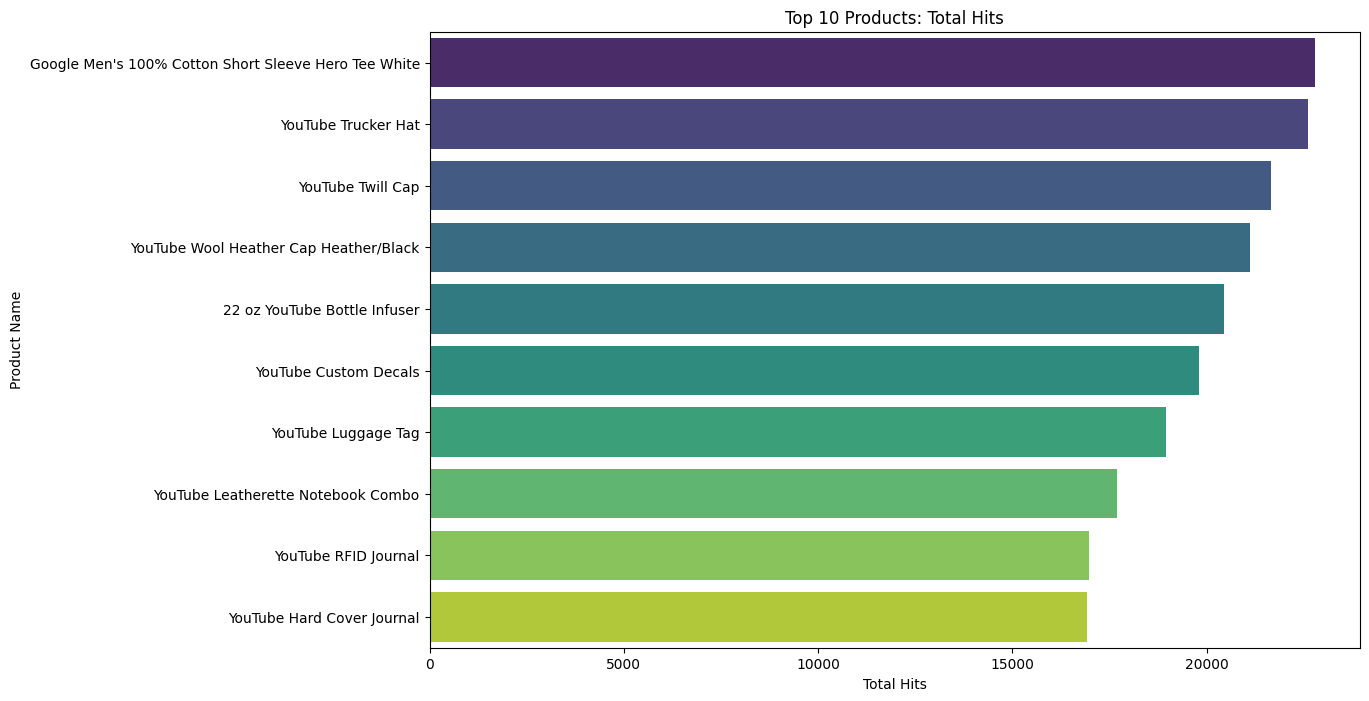

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

# Execute the BigQuery query
client = bigquery.Client()
query = """SELECT
  v2ProductName,
  COUNT(*) AS totalHits
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hit,
  UNNEST(hit.product) AS product
WHERE
  _TABLE_SUFFIX BETWEEN '20170301' AND '20170331'
  AND product.v2productName IS NOT NULL
GROUP BY
  v2ProductName
ORDER BY
  totalHits DESC"""

df = client.query(query).to_dataframe()

# Set the number of top products to show
top_n_products = 10

# Get the top N products based on total hits
top_products = df.head(top_n_products)

# Plotting the horizontal bar graph
plt.figure(figsize=(12, 8))
sns.barplot(x='totalHits', y='v2ProductName', data=top_products, palette='viridis')
plt.title(f'Top {top_n_products} Products: Total Hits')
plt.xlabel('Total Hits')
plt.ylabel('Product Name')
plt.show()





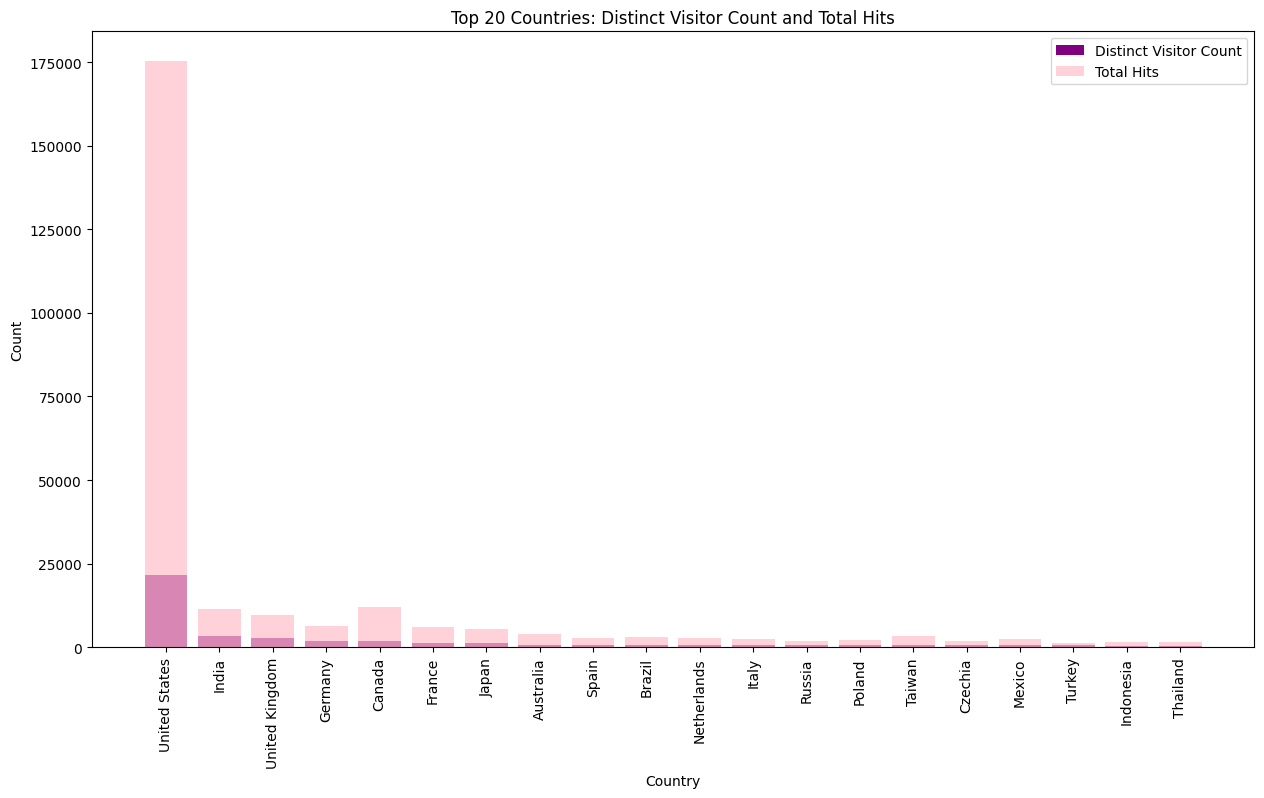

In [160]:
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()
import matplotlib.pyplot as plt
import seaborn as sns
query="""SELECT
  geoNetwork.country AS country,
  COUNT(DISTINCT fullVisitorId) AS distinctVisitorCount,
  COUNT(hit.hitNumber) AS totalHits
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hit
WHERE
  _TABLE_SUFFIX BETWEEN '20170101' AND '20170131'  -- Adjust the date range as needed
  AND geoNetwork.country IS NOT NULL
GROUP BY
  geoNetwork.country
ORDER BY
  country;"""
job=client.query(query)
df_new_2= job.to_dataframe()

from mpl_toolkits.mplot3d import Axes3D


# Select the top 20 countries
top_countries = df_new_2.nlargest(20, 'distinctVisitorCount')

# Plotting the bar graph
plt.figure(figsize=(15, 8))
plt.bar(top_countries['country'], top_countries['distinctVisitorCount'], color='purple', label='Distinct Visitor Count')
plt.bar(top_countries['country'], top_countries['totalHits'], color='pink', label='Total Hits', alpha=0.7)

# Set labels and title
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Top 20 Countries: Distinct Visitor Count and Total Hits')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()



In [151]:
from sklearn.model_selection import train_test_split
X = df_new.drop('action_type', axis=1)
y=df_new.action_type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [152]:
#dropping the columns which are noise to the data
df_new = df_new.drop([ 'date', 'referralPath','adContent','step','newVisits'], axis=1)
numerical_features = df_new.select_dtypes(include=['number']).columns.tolist()
categorical_features = df_new.select_dtypes(include=['object']).columns.tolist()
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['hitNumber', 'time', 'hour', 'minute', 'productRevenue', 'productPrice', 'productQuantity', 'productListPosition', 'visits', 'hits', 'pageviews', 'timeOnSite']
Categorical Features: ['type', 'currencyCode', 'productSKU_1', 'v2ProductName', 'v2ProductCategory', 'productVariant', 'productBrand', 'productListName', 'promoId', 'promoName', 'promoPosition', 'action_type', 'option', 'browser', 'continent', 'country', 'city']


In [153]:
import pandas as pd
# Assuming 'action' is a column you want to exclude
columns_to_encode = [col for col in categorical_features if col != 'action_type']

# Apply one-hot encoding excluding the 'action' column
df_new_encoded = pd.get_dummies(df_new, columns=columns_to_encode, sparse=True, dtype=int)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df_new_encoded,df_new[numerical_features]], axis=1)
print(df_encoded.shape)
print(df_encoded.head())


(1641678, 2290)
   hitNumber    time  hour  minute  isInteraction  isEntrance  isExit  \
0          1       0    17       0           True        True    <NA>   
1          2    4314    17       0           True        <NA>    <NA>   
2          3   28009    17       1           True        <NA>    <NA>   
3          3   28009    17       1           True        <NA>    <NA>   
4          4  111715    17       2           True        <NA>    <NA>   

   productRevenue  productPrice  productQuantity  ...  hour  minute  \
0            <NA>          <NA>             <NA>  ...    17       0   
1            <NA>          <NA>             <NA>  ...    17       0   
2            <NA>      74990000             <NA>  ...    17       1   
3            <NA>      74990000             <NA>  ...    17       1   
4            <NA>      21990000             <NA>  ...    17       2   

   productRevenue  productPrice  productQuantity productListPosition  visits  \
0            <NA>          <NA>       

In [154]:
df_new['action_type'] = df_new['action_type'].astype(int)




In [155]:
%%bigquery data_df --project $PROJECT_ID
CREATE OR REPLACE VIEW p_bq.data AS (
  WITH first_values AS (
    SELECT
    CONCAT(fullVisitorId, '_', visitId,hits.hitnumber) AS unique_id,
      fullVisitorId,
      visitId,
      date,
      visitNumber,
      device.deviceCategory AS device_category,
      device.operatingSystem AS operating_system,
      trafficSource.source AS traffic_source,
      trafficSource.campaign AS traffic_campaign,
      geoNetwork.country AS country,
      geoNetwork.city AS city,
      totals.bounces,
      totals.hits,
      totals.newVisits,
      totals.timeOnSite AS time_on_site,
      totals.visits,
      totals.pageviews AS pageviews_per_session,
      hits.hitNumber As number,
      hits.time AS hitTime,
      hits.hour,
      hits.minute, 
      hits.page.pagePath,
      hits.page.hostname,
      hits.page.pageTitle,
      hits.page.pagePathLevel1,
      hits.page.pagePathLevel2,
      hits.page.pagePathLevel3,
      hits.page.pagePathLevel4,
      product.productSKU,
      product.v2ProductName,
      product.v2ProductCategory,
    
      
      IF(hits.eCommerceAction.action_type = '3', 1, 0) AS action_type
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_201703*`,
      UNNEST(hits) AS hits,
      UNNEST(hits.product) AS product
  )
  
  SELECT * 
  FROM first_values
);

SELECT
  *
FROM
 p_bq.data


Query is running:   0%|          |

Downloading:   0%|          |

In [156]:
# Get the number of rows in the dataframe
num_rows = len(data_df)
print(f"Number of rows: {num_rows}")


Number of rows: 1157382


In [157]:
# Display the first few rows of the dataframe
data_df.head()



,unique_id,fullVisitorId,visitId,date,visitNumber,device_category,operating_system,traffic_source,traffic_campaign,country,...,hostname,pageTitle,pagePathLevel1,pagePathLevel2,pagePathLevel3,pagePathLevel4,productSKU,v2ProductName,v2ProductCategory,action_type
0,9895863469673770148_14905847765,9895863469673770148,1490584776,20170326,1,desktop,Windows,bing,(not set),United States,...,shop.googlemerchandisestore.com,Google | Shop by Brand | Google Merchandise Store,/google+redesign/,/shop+by+brand/,/google,,GGOEGDHB072099,Google Insulated Stainless Steel Bottle,Home/Shop by Brand/Google/,0
1,9895863469673770148_14905847765,9895863469673770148,1490584776,20170326,1,desktop,Windows,bing,(not set),United States,...,shop.googlemerchandisestore.com,Google | Shop by Brand | Google Merchandise Store,/google+redesign/,/shop+by+brand/,/google,,GGOEGEVB070599,Google G Noise-reducing Bluetooth Headphones,Home/Shop by Brand/Google/,0
2,9895863469673770148_14905847765,9895863469673770148,1490584776,20170326,1,desktop,Windows,bing,(not set),United States,...,shop.googlemerchandisestore.com,Google | Shop by Brand | Google Merchandise Store,/google+redesign/,/shop+by+brand/,/google,,GGOEGEHQ071199,"Google High Capacity 10,400mAh Charger",Home/Shop by Brand/Google/,0
3,9895863469673770148_14905847766,9895863469673770148,1490584776,20170326,1,desktop,Windows,bing,(not set),United States,...,shop.googlemerchandisestore.com,Writing Instruments | Office | Google Merchand...,/google+redesign/,/office/,/writing+instruments,,GGOEGOAQ012899,Ballpoint LED Light Pen,Home/Office/Writing Instruments/,0
4,9895863469673770148_14905847766,9895863469673770148,1490584776,20170326,1,desktop,Windows,bing,(not set),United States,...,shop.googlemerchandisestore.com,Writing Instruments | Office | Google Merchand...,/google+redesign/,/office/,/writing+instruments,,GGOEGOAR013599,Ballpoint Stylus Pen,Home/Office/Writing Instruments/,0


In [159]:
data_df.to_csv("cap_03.csv", index= 'false')
